<a href="https://colab.research.google.com/github/Soukainnaaa/Soukainnaaa/blob/main/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall --yes opencv-contrib-python opencv-python

  Successfully uninstalled opencv-contrib-python-4.8.0.76
Found existing installation: opencv-python 4.8.0.76
Uninstalling opencv-python-4.8.0.76:
  Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
!pip  install opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 9.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"soukii","key":"c6d4cc522a9dee526013948194d442a4"}'}

In [ ]:
 ! mkdir ~/.kaggle

 ! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sshikamaru/car-object-detection

 96% 108M/112M [00:00<00:00, 228MB/s] 
100% 112M/112M [00:00<00:00, 218MB/s]


In [ ]:
!unzip /content/car-object-detection.zip -d car-object-detection

Archive:  /content/car-object-detection.zip
  inflating: car-object-detection/data/sample_submission.csv  
  inflating: car-object-detection/data/testing_images/vid_5_25100.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25120.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25140.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25160.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25180.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25200.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25220.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25240.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25260.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26320.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26400.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26420.jpg  
  inflating: car-object-detec

In [ ]:
print('Image(Train):', len(os.listdir('/content/car-object-detection/data/training_images')))
print('Image(Test):', len(os.listdir('/content/car-object-detection/data/testing_images')))


Image(Train): 1001
Image(Test): 175


In [ ]:
Data=pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')

In [ ]:
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
print('nombre de localisation dans Train data:', len(Data))


nombre de localisation dans Train data: 559


In [ ]:
Data.values.shape

(559, 5)

Annotations (Check)

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


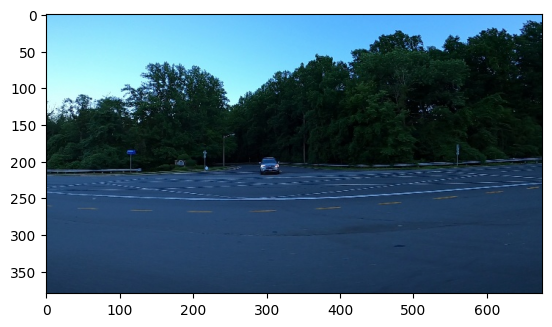

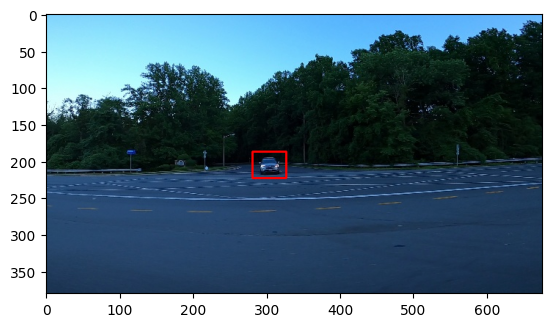

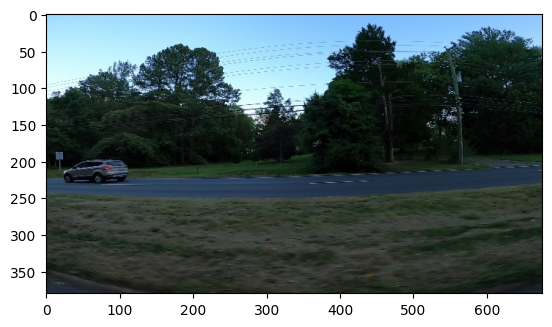

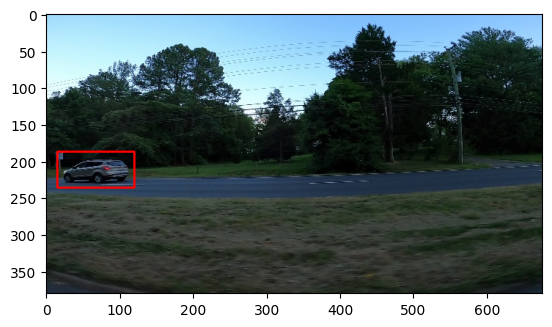

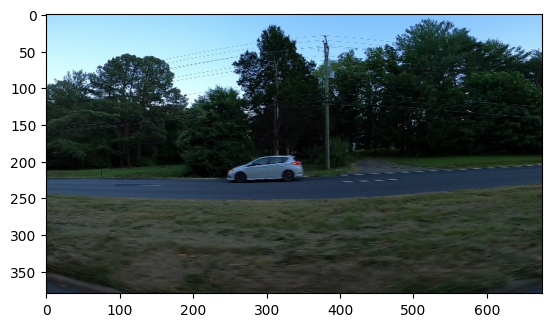

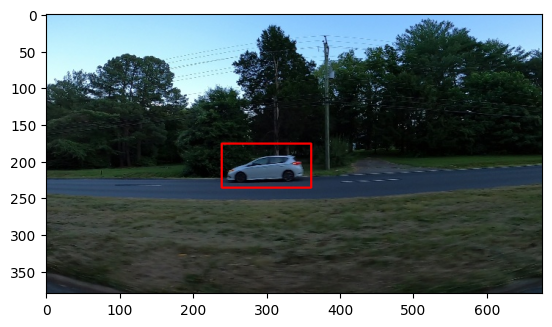

In [ ]:
for a,i in enumerate(Data.values):
  img=plt.imread('/content/car-object-detection/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

Selective Search pour cherhcer ROIs

taille de l'image: (224, 224, 3)
nombre eventuel de boites englobantes: 213


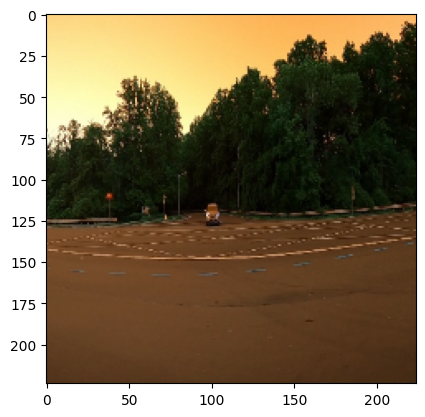

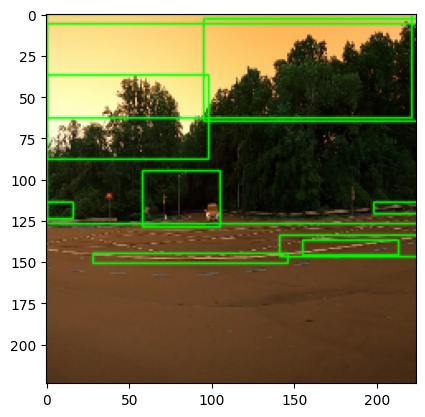

In [ ]:
cv2.setUseOptimized(True) #Optimisation
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() #Creation

im = cv2.imread('/content/car-object-detection/data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) #chargement de l'image
ss.switchToSelectiveSearchFast()# utilisation de la version fast de l'algo de la recherche selective
rects= ss.process()# recuperation des boites englobantes
print("taille de l'image:", im.shape)
print("nombre eventuel de boites englobantes:", len(rects))

for rect in rects[:10]:
  x,y,w,h = rect
  imOut=cv2.rectangle(im,(x,y), (x+w, y+h), (0,255,0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut)


In [ ]:
print(rect)

[ 95   3 129  62]


IOU algorithme

In [ ]:
ss=cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1,bb2):
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']

  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2'];

  x_left= max(bb1['x1'], bb2['x1'])
  y_top= max(bb1['y1'], bb2['y1'])
  x_right= min((bb1['x2'], bb2['x2']))
  y_bottom= min((bb1['y2'], bb2['y2']))

  if x_right < x_left or y_bottom < y_top:
    return 0.0
  intersection_area = (x_right -  x_left) * ( y_bottom - y_top)
  bb1_area =(bb1['x2'] - bb1['x1'])* (bb1['y2']-bb1['y1'])
  bb2_area =(bb2['x2'] - bb2['x1'])* (bb2['y2']-bb2['y1'])
  iou= intersection_area / float(bb1_area  + bb1_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

Recuperation des ROIs à partir de chaque image de la BD

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

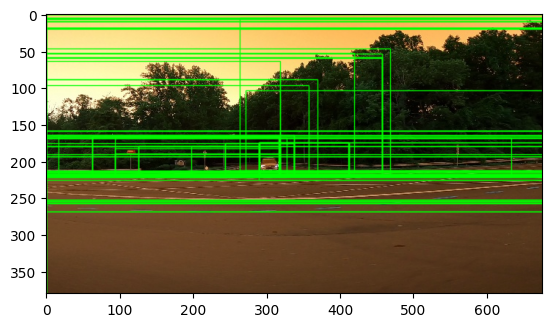

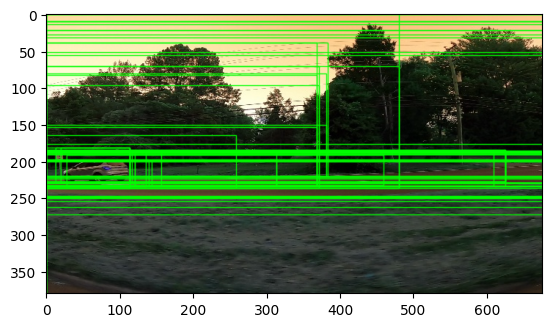

In [ ]:
def getBDImage(image,ROI,bbreel):
  image_liste=[]
  labels=[]
  ious=[]
  rois=[]
  for rect in ROI:
    x, y, w, h = rect
    bbRoi={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
    rois.append(bbRoi)
    imgExtraite=image[bbRoi['y1']:bbRoi['y2'],bbRoi['x1']:bbRoi['x2']] # Crop img
    img_reshape=cv2.resize(imgExtraite,(224,224))
    iou=get_iou(bbreel,bbRoi)
    ious.append(iou)
    #print(iou)
    if iou>0.5:
              image_liste.append([img_reshape])
              labels.append(1)

    else:
      image_liste.append([img_reshape])
      labels.append(0)

  return image_liste,labels,rois,ious



def visualisation(image,ROIs,bbreel):

  image_liste,labels,rois,iou=getBDImage(img,ROIs,bbreel)
  print(labels)

  for i in range(len(labels)):
    if(labels[i]==1):
      bb=rois[i]

      cv2.rectangle(image, (bb["x1"], bb["y1"]), (bb["x2"], bb["y2"]), (0, 255, 0), 1, cv2.LINE_AA)
  plt.figure()
  plt.imshow(image)
for i,a in enumerate(Data.values):
  Name,xmin,ymin,xmax,ymax=a
  bbreel={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  img=cv2.imread('/content/car-object-detection/data/training_images/'+Name)
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ROIs = ss.process()

  #image_liste,labels,rois,iou=getBDImage(img,ROIs,bbreel)
  visualisation(img,ROIs,bbreel)
  if i==1:
    break